In [1]:
%load_ext autoreload
%autoreload 2

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from emissions.trainer import Trainer
import numpy as np
from emissions.data import load_data, clean_data

## Background

### ABQ CURRENT POLICY

- New Mexico emissions tests must be performed on all Bernalillo County vehicles 35 years old and newer.
- All diesel vehicles are exempt from emissions testing.
- Vehicles weighing more than 10,000 lbs do not require an emissions test.
- Any vehicle (including gas-electric hybrid vehicles) must pass an emissions test every two years, or any time the vehicle’s ownership changes, even if the emissions inspection sticker has not yet expired.
- Motorcycles, ATV’s, boats, and scooters do not require an emissions test.

### ABQ CURRENT EMISSIONS TESTING INCLUDES:

- Pollution control equipment check that includes the catalytic converter and other connections.
- On-Board Diagnostic (OBDII) computer car emission test on vehicles 1996 and newer.
- Any visible car smoke test to uncover burning oil or poor fuel combustion that results in toxic emissions.
- Gas cap check to search for vapor leaks.
- Tailpipe exhaustion analysis on vehicles manufactured between 1983 and 1995.

### ABQ Failed Emissions Test Resource Center
- The Vehicle Pollution Management Division (VPMD) offers one free retest for vehicles that do not pass an emissions test within 90 days of the failed test date

## How the implementation of our solution would reduce vehicle pollution?

### Should we use 2020 data?
2020 is a special year because of Covid. Let's look at whether it also influenced vehicle emissions test.


outcome:
1. Don't see clear changes in number of total tests for 2020
2. Don't see share of fails changing for 2020
3. Don't see changes in testing speed for 2020

It seems that Covid didn't have big impact on vehicle emissions test in 2020.

In [107]:
from emissions.data import load_data
df = load_data()
df.head()

----------------start loading data----------------
Data loaded: 187503 records


,TEST_TYPE,TEST_SDATE,VIN,VEHICLE_TYPE,MODEL_YEAR,GVWR,ENGINE_SIZE,TRANS_TYPE,ODOMETER,MAKE,RESULT
0,A,2013-03-04 10:11:00,1G4HP52K45U160372,1,2005,3875,3800,A,114034,BUICK,0
1,I,2013-07-22 16:55:00,3VWSF71K66M706988,1,2006,3250,2500,M,76338,VOLKSWAGEN,0
2,I,2013-06-18 12:45:00,1FTRX17W43NA86035,3,2003,6050,4600,A,104849,FORD,0
3,I,2013-05-29 16:17:00,JTEEP21A560170542,4,2006,5360,3300,A,70130,TOYOTA,0
4,I,2013-04-22 15:54:00,1G1ZT52865F313274,1,2005,3375,3500,A,133251,CHEVROLET,1


In [108]:
df = df[['TEST_SDATE', 'RESULT']]

In [109]:
# share of Fails in 2020 and before 2020
df['YEAR'] = pd.to_datetime(df.TEST_SDATE).dt.year
df['2020'] = (df.YEAR >= 2020).astype(int)
tmp = df.groupby('2020')['RESULT'].value_counts(normalize=True).unstack(level=1).round(3)
tmp.columns = ['Pass (%)', 'Fail (%)']
tmp = tmp.rename({0: 'before 2020', 1:'2020'})
tmp.index.name = ''
tmp

,Pass (%),Fail (%)
,,
before 2020,0.926,0.074
2020,0.930,0.070


Text(0, 0.5, 'total number of tests')

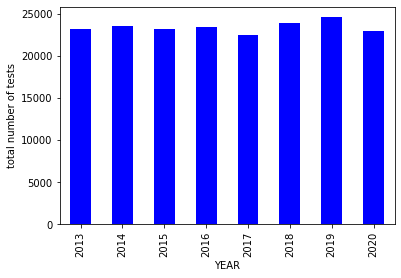

In [110]:
# number of tests each year
df['test_counter'] = 1
df.groupby('YEAR')['test_counter'].sum().plot(kind='bar', color='blue')
plt.ylabel('total number of tests')

Text(0, 0.5, 'share of fails (%)')

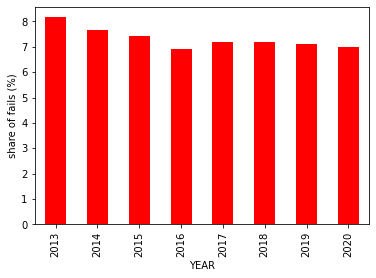

In [144]:
# share of failed tests each year
df['fail_counter'] = df.RESULT
(df.groupby('YEAR')['fail_counter'].mean()*100.0).plot(kind='bar', color='red')
plt.ylabel('share of fails (%)')

In [117]:
df = df.set_index(pd.DatetimeIndex(df.TEST_SDATE))
df = df.drop(columns='TEST_SDATE')
df.sort_values('TEST_SDATE', inplace=True)
df.head()

,RESULT,YEAR,2020,test_counter,fail_counter
TEST_SDATE,,,,,
2013-01-01 14:10:00,0,2013,0,1,0
2013-01-02 07:46:00,0,2013,0,1,0
2013-01-02 08:58:00,0,2013,0,1,0
2013-01-02 09:09:00,1,2013,0,1,1
2013-01-02 09:10:00,0,2013,0,1,0


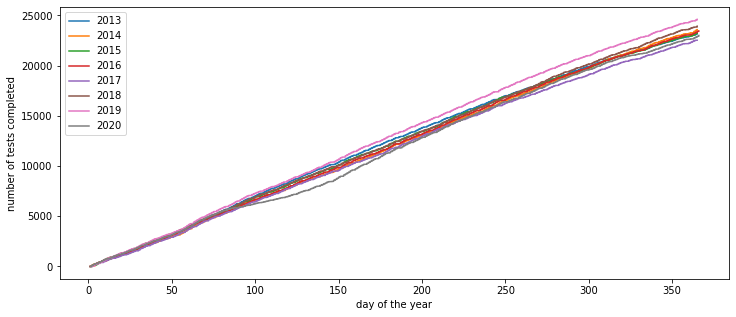

In [148]:
# number of tests along the year
plt.figure(figsize=(12, 5))
for year in df.YEAR.unique():
    t = df[df.YEAR==year].copy()
    t.index = t.index.dayofyear
    plt.plot(t.test_counter.cumsum(), label=f'{year}')
plt.legend()
plt.xlabel('day of the year')
plt.ylabel('number of tests completed');

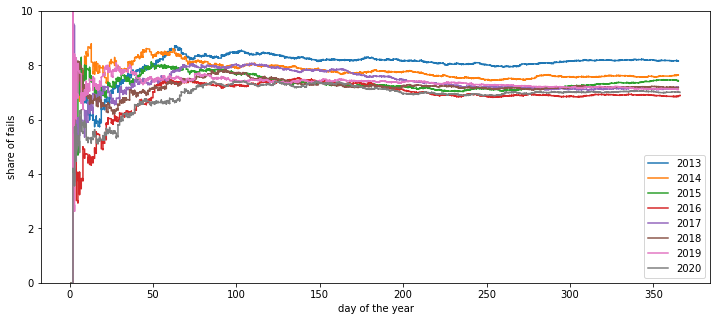

In [146]:
# share of fails along the year
plt.figure(figsize=(12, 5))
for year in df.YEAR.unique():
    t = df[df.YEAR==year].copy()
    t.index = t.index.dayofyear
    plt.plot(100.0*(t.fail_counter.cumsum()/t.test_counter.cumsum()), label=f'{year}')
plt.legend()
plt.ylim(0, 10)
plt.xlabel('day of the year')
plt.ylabel('share of fails');

### How different 2020 could have been with our preliminary system

#### importing data and split train (before 2020) and test (2020) set

In [149]:
df = load_data()
df_all = clean_data(df)

----------------start loading data----------------
Data loaded: 187503 records
----------------start cleaning data----------------

Records in input data: 187503

Share of Pass and Fail before cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10813
Unique vehicles in Pass: 84908

Records with missing GVWR: 8125

Records after droping rows where GVWR is < 1000 or missing: 179373

Records after keeping only the earliest test within a month for each vehicle: 165732

Records where AFTER_COVID is True: 21325

Records where ODOMETER = 0: 796

Records after droping rows where ODOMETER is missing: 164855

Records after droping rows where MILE_YEAR > 40,000: 163891

Records in output data:163891

Share of Pass and Fail after cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10194
Unique vehicles in Pass: 78573
['VEHICLE_TYPE' 'MODEL_YEAR' 'VEHICLE_AGE' 'MILE_YEAR' 'GVWR'
 'ENGINE_SIZE' 'TRANS_TYPE' 'TEST_TYPE' 'RESULT' 'MAKE'
 'ENGINE_WEIGHT_RATIO' 'SPORT' 'TEST_SDATE' 'AFTER_COVID']


In [150]:
# train < 2020 test 2020 split 

df_all['count_test'] = 1
df_all['count_fail'] = df_all.RESULT
train = df_all[df_all.TEST_SDATE.dt.year < 2020].sort_values('TEST_SDATE')
test = df_all[df_all.TEST_SDATE.dt.year == 2020].sort_values('TEST_SDATE')
y_train = train.pop('RESULT')
X_train = train
y_test = test.pop('RESULT')
X_test = test
X_train.shape, y_train.shape

((142916, 15), (142916,))

#### recall or precision?


In [ ]:
cols = ['VEHICLE_AGE', 'MILE_YEAR', 'MAKE', 'MODEL_YEAR', 'ENGINE_WEIGHT_RATIO']

In [ ]:
# best estimator with recall
trainer = Trainer(X_train[cols], 
                  y_train,
                  metric='recall',
                  with_categorical=['MAKE'],
                  max_depth=np.arange(3, 10, 1)
         )
trainer.grid_search()
tmp = trainer.evaluate(X_test[cols], y_test)
print(trainer.search_result.best_params_)
trainer.learning_curve()
tmp


57 make labels each account for less than 1.0% of cars and together account for 9.17% of cars


,train,val,test
accuracy,0.633,0.631,0.623
recall,0.736,0.724,0.725
precision,0.131,0.129,0.117


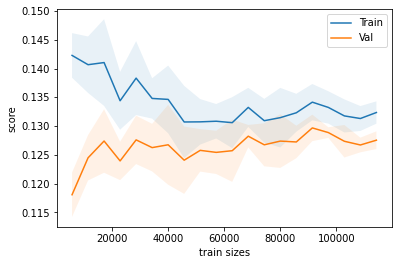

In [27]:
# best estimator with precision
cols = ['VEHICLE_AGE', 'MILE_YEAR', 'MAKE']
from emissions.trainer import Trainer
trainer2 = Trainer(X_train[cols], 
                   y_train, 
                   metric='precision',
                   max_depth=np.arange(2, 10, 1)
          )
trainer2.grid_search()
tmp2 = trainer2.evaluate(X_test[cols], y_test)
print(trainer2.search_result.best_params_)
trainer2.learning_curve()
tmp2

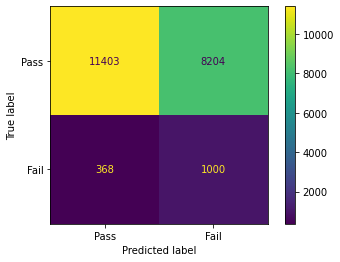

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(trainer.search_result.best_estimator_, X_test[cols], y_test, display_labels=["Pass", "Fail"])

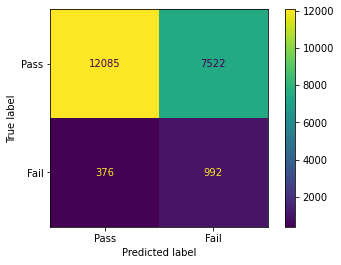

In [29]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(trainer2.search_result.best_estimator_, X_test[cols], y_test, display_labels=["Pass", "Fail"])

In [54]:
total_test = X_test.shape[0]
n_fail_2020 = 1368
# best estimator with recall
precision1 = 0.109
n_fail_pred1 = 9204
n_fail_captured1 = 1000
# best estimator with precision
precision2 = 0.117
n_fail_pred2 = 8514
n_fail_captured2 = 992

In [73]:
total_test

20975

In [55]:
# create cum_tests and cum_fails columns
df = X_test[['TEST_SDATE', 'count_fail', 'count_test']].copy()
df.set_index('TEST_SDATE', inplace=True)
df['n_test'] = df.count_test.cumsum()
df['n_fail'] = df.count_fail.cumsum()
df.drop(columns=['count_test', 'count_fail'], inplace=True)
df.head()

,n_test,n_fail
TEST_SDATE,,
2020-01-01 09:52:37,1,0
2020-01-01 13:44:43,2,0
2020-01-01 15:32:25,3,0
2020-01-01 15:51:44,4,0
2020-01-02 08:11:22,5,0


In [56]:
# define a function to create number of fails captured along 2020 with our solution

def create_n_fail(data, precision, n_fail_pred, n_fail_captured):
    """ 
    takes a df with n_test and n_fail columns, 
    precision: precision score on 2020 test set
    n_fail_pred: number of fails predicted for 2020
    n_fail_captures: number of predicted fails that are true fails
    returns a panda series: number of fails captured along the time
    """
    df = data.copy()
    col = 'n_fail_cap'
    # first test all the predicted fails
    df[col] = df.n_test * precision

    # changes after finish testing predicted fails
    tests_left = df[df.n_test > n_fail_pred].shape[0]
    fails_left = n_fail_2020 - n_fail_captured
    avg_fail_per_test = fails_left/tests_left
    df.loc[df.n_test > n_fail_pred, col] = \
        n_fail_captured + (df[df.n_test > n_fail_pred]['n_test'] - n_fail_pred)*avg_fail_per_test

    # changes after capturing all the true fails
    df.loc[df[col] > n_fail_2020, col] = n_fail_2020
    return df[col]

df['n_fail_recall'] = create_n_fail(df, precision1, n_fail_pred1, n_fail_captured1)
df['n_fail_precision'] = create_n_fail(df, precision2, n_fail_pred2, n_fail_captured2)
df.head()

,n_test,n_fail,n_fail_recall,n_fail_precision
TEST_SDATE,,,,
2020-01-01 09:52:37,1,0,0.109,0.117
2020-01-01 13:44:43,2,0,0.218,0.234
2020-01-01 15:32:25,3,0,0.327,0.351
2020-01-01 15:51:44,4,0,0.436,0.468
2020-01-02 08:11:22,5,0,0.545,0.585


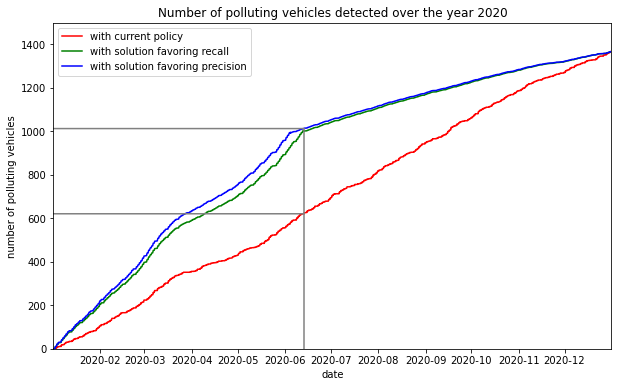

In [72]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df.index, df.n_fail, label='with current policy', c='red')
plt.plot(df.index, df.n_fail_recall, label='with solution favoring recall', c='green')
plt.plot(df.index, df.n_fail_precision, label='with solution favoring precision', c='blue')
t0 = df[df.n_test==n_fail_pred1].index[0]
n_fails_precision_t0 = df[df.index==t0].n_fail_precision[0]
n_fails_t0 = df[df.index==t0].n_fail[0]
plt.plot([t0 for i in range(100)], np.linspace(0, n_fails_precision_t0, 100), c='grey')
plt.plot(df[df.index < t0].index, [n_fails_precision_t0 for i in range(df[df.index < t0].shape[0])], c='grey')
plt.plot(df[df.index < t0].index, [n_fails_t0 for i in range(df[df.index < t0].shape[0])], c='grey')
plt.ylim(0, 1500)
plt.xlim(df.index.min(), df.index.max())
plt.ylabel('number of polluting vehicles')
plt.xlabel('date')
plt.legend()
plt.title('Number of polluting vehicles detected over the year 2020');

Whether to use recall or precision is a decision of ours not our clients.

#### How different 2020 could have been?

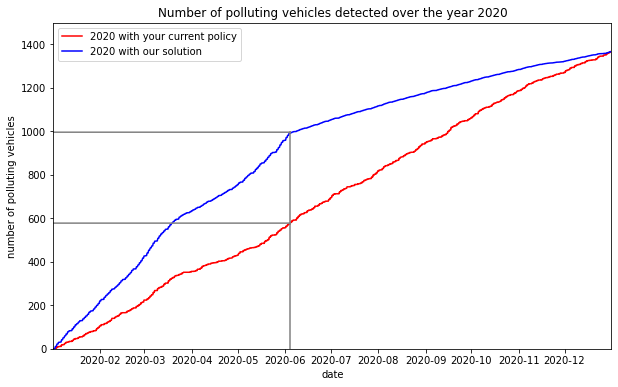

In [70]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df.index, df.n_fail, label='2020 with your current policy', c='red')
plt.plot(df.index, df.n_fail_precision, label='2020 with our solution', c='blue')
t0 = df[df.n_test==n_fail_pred2].index[0]
n_fails_precision_t0 = df[df.index==t0].n_fail_precision[0]
n_fails_t0 = df[df.index==t0].n_fail[0]
plt.plot([t0 for i in range(100)], np.linspace(0, n_fails_precision_t0, 100), c='grey')
plt.plot(df[df.index < t0].index, [n_fails_precision_t0 for i in range(df[df.index < t0].shape[0])], c='grey')
plt.plot(df[df.index < t0].index, [n_fails_t0 for i in range(df[df.index < t0].shape[0])], c='grey')
plt.ylim(0, 1500)
plt.xlim(df.index.min(), df.index.max())
plt.ylabel('number of polluting vehicles')
plt.xlabel('date')
plt.legend()
plt.title('Number of polluting vehicles detected over the year 2020');

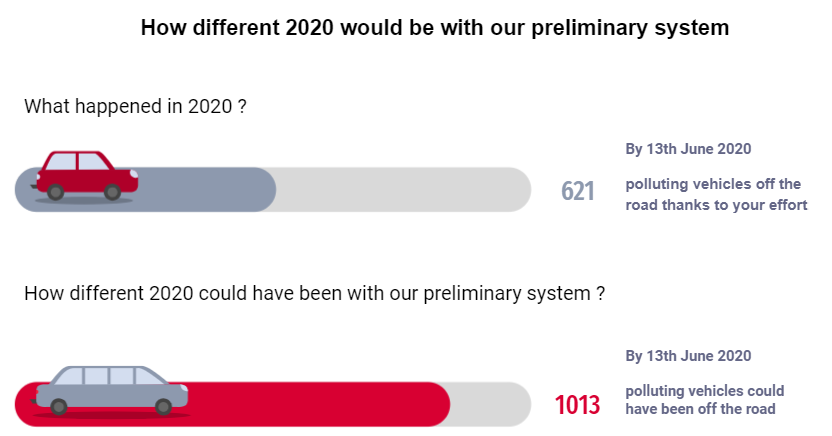


### What about 2019?